In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg
from copy import copy
from scipy.optimize import root
from scipy import sparse as sp
from scipy.sparse.linalg import inv
import imageio

# Question 3

In [2]:
data = np.load('circles.npy')

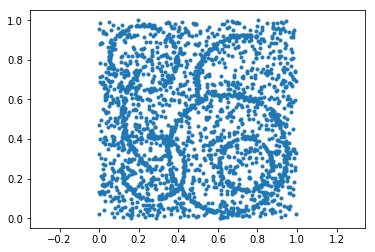

In [3]:
fig, ax = plt.subplots(1, 1)
ax.plot(data[:,0], data[:,1], ls='none', marker='.')
ax.axis('equal')
plt.show()

## RANSAC

In [4]:
# this is the algebraic distance solution to fit a circle
# for RANSAC I will use it only with three points
def fit_circle_to_points(x, y):
    
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # calc beta
    beta = linalg.lstsq(A,b)[0]
    
    # calc params from beta
    cx = beta[0]/2
    cy = beta[1]/2
    r = np.sqrt(beta[2] + cx**2 + cy**2)
    return cx, cy, r


def fit_one_circle(x, y, n=5000, epsilon=0.005):
    # store the current inlier indices
    inlier = []
    # current circle parameters
    circle = None
    
    # well...
    indices = np.arange(len(x), dtype=int)
    
    for _ in range(n):
        # get three random points...
        point_ints = np.random.randint(0, high=len(x), size=3, dtype=int)
        # ... and fit a circle to it
        xc, yc, r = fit_circle_to_points(x[point_ints], y[point_ints])
        # calculate distance matrix...
        dist = np.sqrt((x - xc)**2 + (y - yc)**2) - r
        # ... and select only the ones smaller than epsilon
        current_inlier = indices[np.abs(dist) < epsilon]
        
        # if new best circle: store everything
        if len(current_inlier) > len(inlier):
            inlier = current_inlier
            circle = (xc, yc, r)
            
    return circle, inlier

def fit_circles(data, n = 5):
    testset = copy(data)
    
    circles = []
    
    for _ in range(n):
        # fit a circle to current testset
        circle_data, inlier = fit_one_circle(testset[:,0], testset[:,1])
        # store the circle
        circles.append((circle_data, copy(testset[inlier])))
        
        # unset all inliers
        mask = np.ones(len(testset), dtype=bool)
        mask[inlier] = False
        testset = testset[mask]
    
    return circles
    

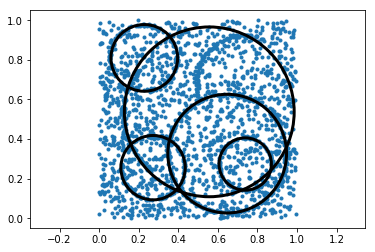

In [5]:
circles = fit_circles(data)
fig, ax = plt.subplots(1, 1)
for i, circle in enumerate(circles):
    artist_circle = plt.Circle((circle[0][0], circle[0][1]), radius=circle[0][2], fill=False, lw=3, zorder=i+1)
    ax.add_artist(artist_circle)
ax.plot(data[:,0], data[:,1], ls='none', marker='.', zorder=0)
ax.axis('equal')
plt.show()

## Algebraic distance

In [6]:
refined_circles = []
for circle in circles:
    refined_circles.append(fit_circle_to_points(circle[1][:,0], circle[1][:,1]))

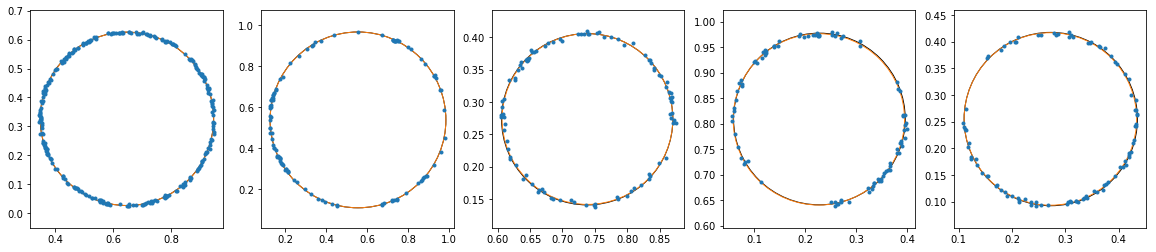

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(len(circles)):
    artist_circle = plt.Circle((circles[i][0][0], circles[i][0][1]), radius=circles[i][0][2], fill=False)
    ax[i].add_artist(artist_circle)
    artist_circle_ref = plt.Circle((refined_circles[i][0], refined_circles[i][1]), radius=refined_circles[i][2], color='C1', fill=False)
    ax[i].add_artist(artist_circle_ref)
    ax[i].axis('equal')
    ax[i].plot(circles[i][1][:,0], circles[i][1][:,1], ls='none', marker='.')
plt.show()

In the plot the blue dots are the inliers, the black line is the circle from RANSAC and the orange one the refined circle from the algebraic distance.

## Geometric distance

We will use Levenberg-Marquardt to find the root of the derivative of $F = \sum_i d_i(x_0, y_0, r)^2 = \sum_i (\sqrt{(x_i - x_0)^2 + (y_i - y_0)^2} - r)^2$. There we find a minimum for F.

The derivatives of F are given as
\begin{align}
\frac{\partial F}{\partial x_0} &= \sum_i \frac{\partial d_i}{\partial x_0} * 2 * d_i\\
\frac{\partial F}{\partial y_0} &= \sum_i \frac{\partial d_i}{\partial y_0} * 2 * d_i\\
\frac{\partial F}{\partial r} &= \sum_i \frac{\partial d_i}{\partial r} * 2 * d_i
\end{align}
where
\begin{align}
\frac{\partial d_i}{\partial x_0} &= \frac{x_i - x_0}{\sqrt{(x_i - x_0)^2 + (y_i - y_0)^2}}\\
\frac{\partial d_i}{\partial y_0} &= \frac{y_i - y_0}{\sqrt{(x_i - x_0)^2 + (y_i - y_0)^2}}\\
\frac{\partial d_i}{\partial r} &= -1
\end{align}


In [8]:
def lm_circle_eq(param, data):
    data = data[0]
    # calculate d
    d = np.sqrt((data[:,0] - param[0])**2 + (data[:,1] - param[1])**2) - param[2]
    df = np.empty(3)
    # calculate df
    df[0] = np.sum(2*d*(data[:,0] - param[0])/np.sqrt((data[:,0] - param[0])**2 + (data[:,1] - param[1])**2))
    df[1] = np.sum(2*d*(data[:,1] - param[1])/np.sqrt((data[:,0] - param[0])**2 + (data[:,1] - param[1])**2))
    df[2] = np.sum(-2*d)
    
    return df


In [11]:
lm_circles = []
for circle in circles:
    sol = root(lm_circle_eq, circle[0], args=[circle[1]], method='lm')
    lm_circles.append(sol["x"])

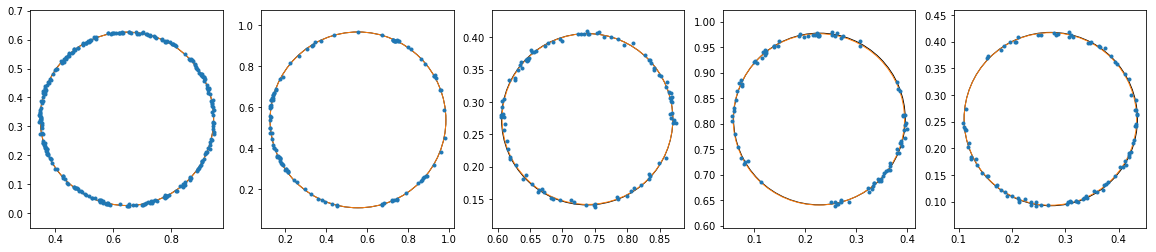

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(len(circles)):
    artist_circle = plt.Circle((circles[i][0][0], circles[i][0][1]), radius=circles[i][0][2], fill=False)
    ax[i].add_artist(artist_circle)
    artist_circle_ref = plt.Circle((lm_circles[i][0], lm_circles[i][1]), radius=lm_circles[i][2], color='C1', fill=False)
    ax[i].add_artist(artist_circle_ref)
    ax[i].axis('equal')
    ax[i].plot(circles[i][1][:,0], circles[i][1][:,1], ls='none', marker='.')
plt.show()

In the plot the blue dots are the inliers, the black line is the circle from RANSAC and the orange one the refined circle from the algebraic distance.

## Comparison

In [13]:
def create_noise(circle_data, n, angle=None):
    random_angles = 2*np.pi*np.random.rand(n)
    
    # if angle is specified, draw from normal distribution around this angle
    if angle != None:
        random_angles = np.random.randn(n)*10*np.pi/180 + angle*np.pi/180 # variance is 10 degrees

    outlier_vec = np.zeros((n, 2))
    outlier_vec[:,1] = circle_data[2]*(1 + (np.random.rand(n) - 0.5))
    
    c, s = np.cos(random_angles), np.sin(random_angles)
    
    outliers = np.empty((n, 2))
    
    outliers[:,0] = c*outlier_vec[:,0] - s*outlier_vec[:,1] + circle_data[0]
    outliers[:,1] = s*outlier_vec[:,0] + c*outlier_vec[:,1] + circle_data[1]
    
    return outliers

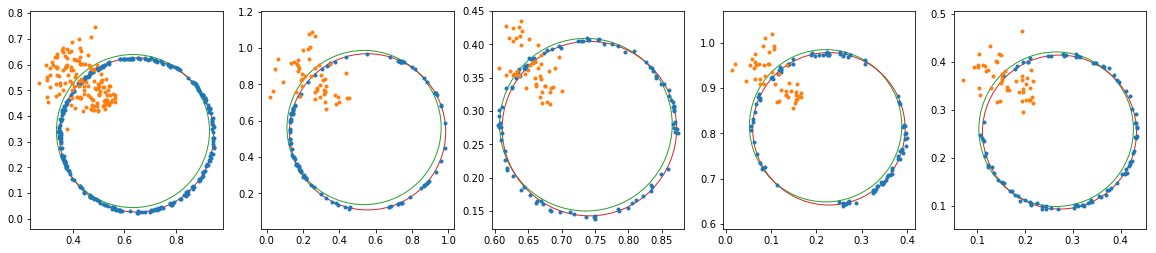

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, circle in enumerate(circles):
    ax[i].axis('equal')
    outliers = create_noise(circle[0], int(0.5*len(circle[1])), angle=45) # 50% outliers
    ax[i].plot(circle[1][:,0], circle[1][:,1], ls='none', marker='.') 
    ax[i].plot(outliers[:,0], outliers[:,1], ls='none', marker='.')
    
    new_set = np.concatenate((circle[1], outliers))
    
    circle_algebraic = fit_circle_to_points(new_set[:,0], new_set[:,1])
    sol = root(lm_circle_eq, circle[0], args=[new_set], method='lm')
    circle_geometric = sol["x"]
    
    algebraic_circle = plt.Circle((circle_algebraic[0], circle_algebraic[1]), radius=circle_algebraic[2], fill=False, color='C2')
    ax[i].add_artist(algebraic_circle)
    geometric_circle = plt.Circle((circle_geometric[0], circle_geometric[1]), radius=circle_geometric[2], fill=False, color='C3')
    ax[i].add_artist(geometric_circle)
plt.show()

In the plot the blue dots are the original inliers, the orange dots are the generated outliers, the green circle is the algebraic method and the red circle is the geometric method. 
As you can see in the plots, the geometric method stays close to the original inliers. The green circle is significantly biased by the outliers.